## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
%run -i "..\open_files"

%matplotlib inline

## Open Files

In [14]:
file_numbers, data_dict, trackMeta_dict, recordMeta_dict = read_files()
# Two Lanes: 1,2,3,15,16,17,18,19,20,21

## Calculation of Speed

In [15]:
car_speed = []
truck_speed = []

# Timestep for the parameters (in seconds)
timestep = 60

for i in (file_numbers):
    # Get necessary information
    data_merged = pd.merge(data_dict[f"data_{i}"], trackMeta_dict[f"data_{i}"][["id", "class", "drivingDirection"]], on="id")
    framerate = recordMeta_dict[f"data_{i}"]["frameRate"].iloc[0]
    duration = int(np.ceil(recordMeta_dict[f"data_{i}"]["duration"].iloc[0]))
    frames = int(np.ceil(duration/timestep))

    # Separate car and truck speed
    car_df = data_merged[data_merged["class"]=="Car"].copy()
    truck_df = data_merged[data_merged["class"]=="Truck"].copy()
    car_xVel = car_df["xVelocity"]
    car_yVel = car_df["yVelocity"]
    truck_xVel = truck_df["xVelocity"]
    truck_yVel = truck_df["yVelocity"]
    
    car_df["velocity"] = np.sqrt(car_xVel**2+car_yVel**2)*3.6
    truck_df["velocity"] = np.sqrt(truck_xVel**2+truck_yVel**2)*3.6
    
    # Take average speed at each time step (1 sec)
    for j in range(frames):
        lb = (framerate*timestep*j)+1
        ub = (j+1)*framerate*timestep
        car_mean = car_df[(car_df["frame"]>=lb) & (car_df["frame"]<=ub) & (car_df["drivingDirection"]==1)]["velocity"].mean()
        truck_mean = truck_df[(truck_df["frame"]>=lb) & (truck_df["frame"]<=ub) & (truck_df["drivingDirection"]==1)]["velocity"].mean()
        car_speed.append(car_mean)
        truck_speed.append(truck_mean)
    car_speed = car_speed[:-1]
    truck_speed = truck_speed[:-1]

In [16]:
len(truck_speed)

146

## Calculation of Density

In [17]:
x1 = 0
x2 = 420
lane_length = x2 - x1
density_list = []
time_span = 900 # seconds
time_interval = 60 # seconds

for i in (file_numbers):
    counts = []
    densities = []
    time_span = int(np.ceil(recordMeta_dict[f"data_{i}"]["duration"].iloc[0]))
    for t in range(0, time_span, time_interval):
        # Calculating Forward Traffic Flow
        mask = (data_dict[f"data_{i}"]["frame"] >= t * recordMeta_dict[f"data_{i}"]["frameRate"][0]) & (data_dict[f"data_{i}"]["frame"] < (t + time_interval) * recordMeta_dict[f"data_{i}"]["frameRate"][0]) & (data_dict[f"data_{i}"]["x"] >= x1) & (data_dict[f"data_{i}"]["x"] <= x2)
        vehicles = data_dict[f"data_{i}"][mask & (data_dict[f"data_{i}"]["y"] >= 0)]["id"].unique()
        count = len(vehicles)
        # Density Caculation Method in Aimsun
        density = count * time_interval / lane_length *1000
        counts.append(count)
        densities.append(density)
    density_list.extend(densities[:-1])

In [18]:
len(density_list)

146

## Calculation of Intensity

In [19]:
pos = 0
intensity_list = []

for i in (file_numbers):
    # Get necessary information
    data_merged = pd.merge(data_dict[f"data_{i}"], trackMeta_dict[f"data_{i}"][["id", "class", "drivingDirection"]], on="id")
    framerate = recordMeta_dict[f"data_{i}"]["frameRate"].iloc[0]
    duration = int(np.ceil(recordMeta_dict[f"data_{i}"]["duration"].iloc[0]))
    frames = int(np.ceil(duration/timestep))

    # Extract needed parameters
    frame = data_merged["frame"]
    x_pos = data_merged["x"]
    width = data_merged["width"]
    veh_type = data_merged["class"]
    direction = data_merged["drivingDirection"]
    num_data = len(frame)

    # Initialize intensity lists
    car_intensity = [0]*frames
    truck_intensity = [0]*frames
    intensity = [0]*frames
    

    # Add to list if car across line (x=0)
    for j in range(num_data):
        if x_pos[j]>=pos-(width[j]/2) and x_pos[j]<=pos+(width[j]/2) and direction[j]==1 and veh_type[j]=="Car":
            k = frame[j] // (framerate*timestep)
            car_intensity[k] += 1
        elif x_pos[j]>=pos-(width[j]/2) and x_pos[j]<=pos+(width[j]/2) and direction[j]==1 and veh_type[j]=="Truck":
            k = frame[j] // (framerate*timestep)
            truck_intensity[k] += 1
        if x_pos[j]>=pos-(width[j]/2) and x_pos[j]<=pos+(width[j]/2) and direction[j]==1:
            k = frame[j] // (framerate*timestep)
            intensity[k] += 1
    intensity = intensity[:-1]
    intensity_list.extend(intensity)

    


In [20]:
len(intensity_list)

146

## Remove Outliers

In [21]:
# from itertools import compress
# deviation = 2

# def remove_outlier(speed, intensity): # add density later
#     speed_mean = np.mean(speed)
#     speed_std = np.std(speed)
#     not_outlier = (abs(speed-speed_mean)<deviation*speed_std)
#     speed_no = list(compress(speed, not_outlier))

#     intensity_mean = np.mean(intensity)
#     intensity_std = np.std(intensity)
#     not_outlier = (abs(intensity-intensity_mean)<deviation*intensity_std)
#     intensity_no = list(compress(intensity, not_outlier))

#     return speed_no, intensity_no

# car_speed_no, car_intensity_no = remove_outlier(car_speed, car_intensity)
# truck_speed_no, intensity_no = remove_outlier(truck_speed, intensity)


## Correlation Coefficients

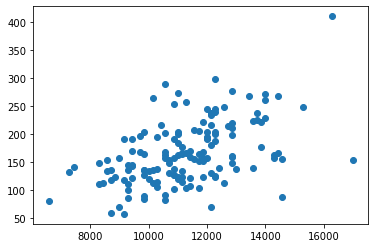

Correlation Coefficient (Density & Intensity): 0.49143310311041244


In [22]:
plt.scatter(density_list, intensity_list)
plt.show()

corrcoef_d_i=np.corrcoef(density_list, intensity_list)[0, 1]
print(f"Correlation Coefficient (Density & Intensity): {corrcoef_d_i}")

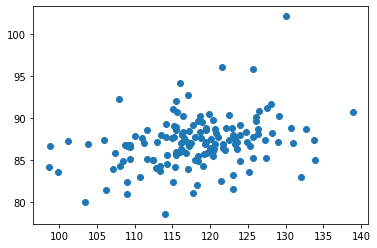

Correlation Coefficient (Car Speed & Intensity): 0.32273026607986943


In [23]:
plt.scatter(car_speed, truck_speed)
plt.show()

corrcoef_cv_tv=np.corrcoef(car_speed, truck_speed)[0, 1]
print(f"Correlation Coefficient (Car Speed & Intensity): {corrcoef_cv_tv}")

In [38]:
df = pd.DataFrame({"Car Speed": car_speed, "Truck Speed": truck_speed, "Intensity": intensity_list, "Density": density_list})
features = ["Car Speed", "Truck Speed", "Intensity", "Density"]
corr_df = pd.DataFrame(columns=features, index=features)
for i in features:
    for j in features:
        coef = np.corrcoef(df[i], df[j])[0, 1]
        corr_df[i][j] = coef
corr_df.head()


,Car Speed,Truck Speed,Intensity,Density
Car Speed,1,0.32273,-0.46702,-0.348012
Truck Speed,0.32273,1,-0.135673,-0.0632623
Intensity,-0.46702,-0.135673,1,0.491433
Density,-0.348012,-0.0632623,0.491433,1


## Principle Component Analysis

              0          1      2             3
0    119.964007  86.391518  156.0  11571.428571
1    115.454683  88.546352  119.0  11000.000000
2    119.220209  85.761294  123.0  12285.714286
3     98.564912  84.117654  269.0  14428.571429
4    106.146305  81.422136  162.0  14285.714286
..          ...        ...    ...           ...
141  124.703406  88.398492  132.0   7285.714286
142  115.426568  85.606322  143.0   9428.571429
143  114.940004  87.590777  133.0  11142.857143
144  118.610133  90.201644  168.0   9714.285714
145  125.673296  87.745594  165.0  11714.285714

[146 rows x 4 columns]


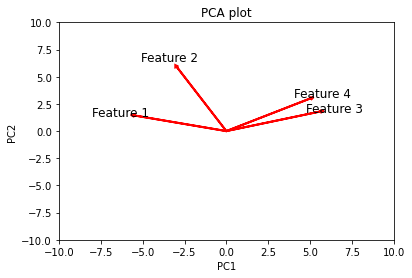

Explained Variance: [0.49197047 0.25123228]
Loadings: [[-0.56212297 -0.30146534  0.57413151  0.51333169]
 [ 0.20563453  0.84034813  0.25811311  0.43000824]]


In [39]:
# Normalize data and convert to matrix

truck_df = pd.DataFrame([car_speed, truck_speed, intensity_list, density_list]).T
print(truck_df)
for col in truck_df.columns:
    truck_df[col] = (truck_df[col]-truck_df[col].mean())/truck_df[col].std()
truck_df = truck_df.dropna(axis="columns")
truck_mat = np.matrix(truck_df)

# Run PCA for trucks
truck_pca = PCA(n_components=2)
truck_pca.fit_transform(truck_mat)
fig, ax = plt.subplots()

# plot arrows representing the original features
feature_vectors = truck_pca.components_.T * np.sqrt(truck_pca.explained_variance_)
arrow_size, text_pos = 7.0, 8.0
for i, v in enumerate(feature_vectors):
    ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], head_width=0.2, head_length=0.2, linewidth=2, color='red')
    ax.text(v[0]*text_pos, v[1]*text_pos, f"Feature {i+1}", color='black', ha='center', va='center', fontsize=12)

# set axis labels and plot title
axes = 10
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA plot')
ax.set_xlim([-axes, axes])
ax.set_ylim([-axes, axes])
plt.show()
print(f"Explained Variance: {truck_pca.explained_variance_ratio_}")
print(f"Loadings: {truck_pca.components_}")

